In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs






# LOAD CONTACT MATRICES
# contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')
# contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed_no_chrY.npy')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_contact_matrix(
    matrix: np.ndarray,
    title: str,
    max_bins: int = 5000,
    vmin: float = 0,
    vmax: float = 99,
    genome_size_bp: int = 3_100_000_000,     # total length of human genome in bp
    n_ticks: int = 5                          # how many ticks on each axis
):
    """
    Plot a Hi-C contact matrix and label axes in genomic megabases.
    
    Parameters
    ----------
    matrix : np.ndarray
        Square contact matrix.
    title : str
        Plot title.
    max_bins : int, optional
        Maximum number of bins to display (will aggregate if larger).
    vmin : float, optional
        Minimum color scale value.
    vmax : float, optional
        Percentile for color scale maximum.
    genome_size_bp : int, optional
        Total genome length in base pairs (default ~3.1e9 for human).
    n_ticks : int, optional
        Number of tick marks per axis.
    """

    # --- (1) optionally aggregate large matrices ---
    n_bins = matrix.shape[0]
    if n_bins > max_bins:
        factor = math.ceil(n_bins / max_bins)
        new_n = math.ceil(n_bins / factor)
        pad_amt = new_n * factor - n_bins
        if pad_amt > 0:
            matrix = np.pad(
                matrix,
                ((0, pad_amt), (0, pad_amt)),
                mode='constant',
                constant_values=np.nan
            )
        matrix = matrix.reshape(new_n, factor, new_n, factor).mean(axis=(1,3))
        n_bins = new_n

    # --- (2) color scale ceiling at the given percentile ---
    vmax_val = np.nanpercentile(matrix, vmax)

    # --- (3) compute resolution (bp per bin) and tick positions/labels ---
    bp_per_bin = genome_size_bp / n_bins
    # tick positions in bin indices
    tick_bins = np.linspace(0, n_bins, num=n_ticks, endpoint=True)
    # convert to Mb
    tick_mbs = (tick_bins * bp_per_bin) / 1e6
    # format labels as integers or one decimal
    tick_labels = [f"{mb:.1f}" if mb < 10 else f"{int(mb)}" for mb in tick_mbs]

    # --- (4) set global font modern ---
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'font.size': 10
    })

    # --- (5) plot matrix ---
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.Reds
    cmap.set_bad(color='white')
    im = ax.imshow(
        matrix,
        cmap=cmap,
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax_val,
        aspect='equal'
    )

    # --- (6) title & axis labels ---
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Genomic position (Mb)", labelpad=8)
    ax.set_ylabel("Genomic position (Mb)", labelpad=8)

    # --- (7) set ticks ---
    ax.set_xticks(tick_bins)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_bins)
    ax.set_yticklabels(tick_labels)

    # --- (8) improved colorbar ---
    cbar = fig.colorbar(im, ax=ax, fraction=0.026, pad=0.04)    
    cbar.set_label("Interaction frequency", fontsize=10, labelpad=6)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()


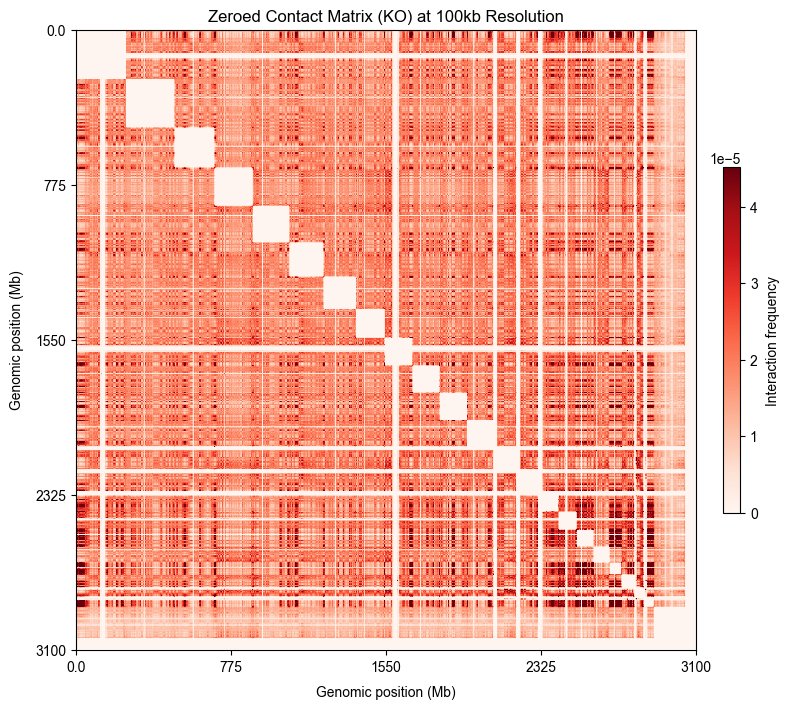

In [4]:
plot_contact_matrix(contact_matrix_zero, "Zeroed Contact Matrix (KO) at 100kb Resolution", max_bins=1000)

In [3]:
neighbors, cdfs = build_walk_index(contact_matrix_zero) 


100%|██████████| 30894/30894 [00:10<00:00, 3006.38it/s]


In [4]:
def optimize_clique_size(
    contact_matrix,
    max_clique_size,
    seed_bin,
    num_samples=1000,
    clique_alg=cf.find_greedy_clique,
    **alg_kwargs
):
    """
    Runs a single full-size clique search with `clique_alg`, then trims down to all sizes.

    Parameters:
    - contact_matrix: Hi-C contact matrix
    - max_clique_size: maximum clique size to search
    - seed_bin: start bin for your TTN clique
    - num_samples: number of random background samples
    - clique_alg: function(contact_matrix, size, seed_bin, **alg_kwargs)
    - alg_kwargs: extra keyword arguments for `clique_alg` (e.g. num_neighbors)

    Returns:
    sizes, ttn_scores, p_values, fold_changes, bg_dists
    """
    print(f"Starting optimize_clique_size: max_clique_size={max_clique_size}, "
          f"seed_bin={seed_bin}, num_samples={num_samples}, alg={clique_alg.__name__}")

    # 1) Full-size TTN clique
    ttn_full = clique_alg(
        contact_matrix,
        max_clique_size,
        seed_bin,
        **alg_kwargs
    )
    print(f"Computed TTN full clique of size {len(ttn_full)} using {clique_alg.__name__}")

    # 2) Background samples (full size)
    bg_full = []
    for _ in tqdm(range(num_samples), desc="Sampling background cliques"):
        rand_bin = np.random.randint(contact_matrix.shape[0])
        bg = clique_alg(
            contact_matrix,
            max_clique_size,
            rand_bin,
            **alg_kwargs
        )
        bg_full.append(bg)
    print("Background sampling complete.")

    sizes = list(range(1, max_clique_size + 1))
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    # 3) Trim & score for each size
    for size in tqdm(sizes, desc="Processing sizes"):

        # TTN subclique
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(
            contact_matrix,
            ttn_sub
        )
 

        # Background scores
        bg_scores = []
        for clique in bg_full:
            sub = clique[:size]
            score = core.stats.calculate_avg_interaction_strength(
                contact_matrix,
                sub
            )
            bg_scores.append(score)
        bg_dists[size] = bg_scores

        # Stats
        median_bg = np.median(bg_scores)
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (num_samples + 1)
        fold = ttn_score / median_bg if median_bg != 0 else float('nan')

        # print(f"  Median background: {median_bg:.4f}")
        # print(f"  p-value: {pval:.4f}")
        # print(f"  Fold change: {fold:.4f}")

        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("Completed optimize_clique_size")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists



In [13]:
ttn_clique_greedy_5 = cf.find_greedy_clique(
    contact_matrix_zero,
    5,
    TTN_BIN,
)

In [11]:
import functions as f

genes = f.find_gene_from_bin(TTN_BIN, BIN_MAP_PATH, GTF_PATH)

In [12]:
genes

['RP11-171I2.5',
 'COL23A1',
 'RP11-65L3.4',
 'TTN-AS1',
 'RP11-385J1.3',
 'KCNMB2-AS1',
 'KCNMB2',
 'RNA5SP69',
 'RP11-171I2.2',
 'PLEKHA3',
 'TEX35',
 'C1orf220',
 'RP11-65L3.3',
 'RP5-990P15.4',
 'TTN',
 'RP11-65L3.2']

In [14]:
GENES = f.get_genes_from_bins(
    ttn_clique_greedy_5,
    BIN_MAP_PATH,
    GTF_PATH
)

Finding genes from bins: 100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


In [15]:
with open('greedy_5_genes.txt', 'w') as f:
    for gene in GENES:
        f.write(f"{gene}\n")
print(f"Found {len(GENES)} genes in TTN clique of size 40")

Found 276 genes in TTN clique of size 40


In [ ]:
sizes, ttn_scores, pvals, folds, bg = optimize_clique_size(
    contact_matrix_zero,
    max_clique_size=40,
    seed_bin=4275,
    num_samples=10000,
    clique_alg=cf.random_walk,
    neighbors=neighbors,
    cdfs=cdfs,
    num_molecules=10000,
    alpha=0.05,  
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8-whitegrid')  # Clean modern look
# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, pvals, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(pvals))
opt_size = sizes[opt_idx]
opt_pval = pvals[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')